In [1]:
import gudhi
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import matplotlib
from matplotlib import colors
from sklearn.metrics import pairwise_distances

from witnesscplx import *
from matplotlib import rc

rc("text", usetex=True)
plt.rcParams["font.family"] = "serif"
plt.rcParams["text.usetex"] = True

import matplotlib.collections

import warnings
warnings.filterwarnings("ignore")
import pickle


In [2]:
def load_and_preprocess_data(city):

    """
    This function processes the landmark and witness data
    
    """
    # witnesses, cooling centers
    CC = pd.read_csv(f'OSM/{city}_cooling_OSM.csv')

    #landmarks, string -> float
    CT = pd.read_csv(f'Centroids/{city}_Centroid_CB.csv')
    CT['X'] = CT['centroid_x'].astype(float)
    CT['Y'] = CT['centroid_y'].astype(float)

    L = np.array([CT['Y'], CT['X']]).T #o reports it as long, lat -> flip
    W = np.array([CC['X'], CC['Y']]).T 

    return L, W





def plot_persistence_diagram(L, W, city):
    
    """
    This function plots the persistance diagram and saves important
    outputs for the persistent homology analysis
    """

    st, filt = WitnessComplexFiltration(L, W)
    persdgm = st.persistence()
    
#     # save as Pickle to use in other notebook
#     with open(f'persdgm_{city}.pkl', 'wb') as f:
#         pickle.dump(persdgm, f)
    
    #plot persistence diagram
    fig, ax = plt.subplots()
    gudhi.plot_persistence_diagram(persdgm, axes=ax)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f'Persistence Diagram for {city}', size = 16)
    plt.show()
    
    birthdeath_pairs = st.persistence_pairs()
    
    return st, filt, birthdeath_pairs
    
    
    
    
    

def plot_city_with_network(city, L, W, df, shapefile_path, st):
    
    """
    This function plots the an example of plots in the filtration and
    saves the .json file for later use
    
    """
    
    # filter data to only city
    df = df[df['Region'] == city]
    gdf = gpd.read_file(shapefile_path)

    # extract the GEOIDs we have demographic data on
    gdf = gdf[['GEOID', 'geometry']]
    gdf['GEOID'] = gdf['GEOID'].astype(int)
    df['GEOID'] = df['GEOID'].astype(int)
    gdf['GEOID'] = gdf['GEOID'].astype(str)
    gdf['GEOID'] = gdf['GEOID'].apply(lambda x: x[:-1]) #read a tract ID and compare to tract ID by deleting last #
    gdf['GEOID'] = gdf['GEOID'].astype(int)
    gdf = gdf[gdf['GEOID'].isin(df['GEOID'])]
    gdf = pd.merge(gdf, df, on='GEOID', how='outer')
    
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    gdf.plot(ax=ax, color='white', edgecolor='grey')
    ax.scatter(W[:, 0], W[:, 1], color='darkslategray', s=12, marker='d', label='Witnesses: Cooling Centers')
    ax.scatter(L[:, 0], L[:, 1], color='darkseagreen', s=12, label='Landmarks: Census Block Centroid',)
    ax.set_title(f'Cooling Centers and Centroids for {city}', size = 14)
    ax.set_xlabel("longitude", size = 12)
    ax.set_ylabel("latitude", size = 12)
    ax.legend(loc = (1.05, 0.4), fontsize = 12)
    
    
    #this code plots the network for certain steps in the filtration
    
#     def plot_network_on_map(ax, verts, edges, f):
    
#         #put verticies back to regular coordinates
#         if len(verts) > 0:
#             ax.set_title(f"{round(f,2)} km")
#             ax.scatter(verts[:,0], verts[:,1], alpha=0.5, s=10, color='darkseagreen')
        
#             coll = matplotlib.collections.LineCollection(edges, linewidth=0.6, alpha=1, color='xkcd:charcoal')
#             ax.add_collection(coll)

#     fig, ax = plt.subplots(1, 4, figsize=(15, 5), sharey=True)

#     # plot the .json file on each network
#     for ax_i in ax:
#         gdf.plot(ax=ax_i, color='white', edgecolor='grey')
#     figcount = 0

#     for f in range(1, 5):
#         #gdf.plot(ax=ax, color='white', edgecolor='grey')
#         verts, edges = GetSublevelSet(st, L, f)
#         plot_network_on_map(ax[figcount], verts, edges, f)
#         figcount += 1

#     plt.tight_layout()
#     #plt.show()
    
    return gdf







def plot_death_simplices(city, gdf, L, st, filt, birthdeath_pairs):
    
    """
    This part of the function plots the 0D homology graph
    """
    
    fig, ax = plt.subplots(figsize=(6, 7))
    #st, filt = WitnessComplexFiltration(L, W)
    
    #plot the .json and scatter plot of landmarks
    gdf.plot(ax=ax, color='white', edgecolor='silver')
    ax.scatter(L[:,0], L[:,1], alpha=0.7, s=10, color='darkseagreen', label='Landmarks (Block Centroids)')
    
    # collect death edges and colors
    death_edges = []
    de_color = []
    for b, d in birthdeath_pairs:
        if len(d) == 2:
            d1, d2 = d
            death_edges.append([L[d1,:], L[d2,:]])
            de_color.append(filt[d1, d2])
    
    # create LineCollection for death simplice
    coll = matplotlib.collections.LineCollection(death_edges, linewidth=2, alpha=0.9, array=de_color, cmap = 'plasma')
    ax.add_collection(coll)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    cbar = plt.colorbar(coll, label='Filtration Value (km)', fraction = 0.046, pad = 0.04)
    cbar.set_ticks([np.min(de_color), np.max(de_color)])
    cbar.set_ticklabels([round(np.min(de_color), 1), round(np.max(de_color), 1)])
    
    ax.set_title(f'Death Simplices for 0D Persistence - {city}', size = 14)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fontsize=12, ncol=1)
    
    
    
    """
    This part of the function plots the 1D homology graph
    """
    
    fig, ax = plt.subplots(figsize=(6, 7))
    
    # plot map and landmarks
    gdf.plot(ax=ax, color='white', edgecolor='silver')
    ax.scatter(L[:,0], L[:,1], alpha=0.7, s=10, color='darkseagreen', label='Landmarks (Block Centroids)')

    # prepare patches and colors for death simplices
    patches = []
    patchcol = []
    for b, simp in birthdeath_pairs:
        if len(simp) == 3:
            xy = [L[vert, :] for vert in simp]
            tri = matplotlib.patches.Polygon(xy, fill=False)
            patches.append(tri)
            patchcol.append(st.filtration(simp))

    # add patches to the plot
    p = matplotlib.collections.PatchCollection(patches, array=patchcol, alpha=0.9, cmap = 'plasma')
    ax.add_collection(p)
    
    ax.set_xticks([])
    ax.set_yticks([])

    cbar = plt.colorbar(p, label='Filtration Value (km)', fraction = 0.046, pad = 0.04)
    cbar.set_ticks([np.min(patchcol), np.max(patchcol)])
    cbar.set_ticklabels([round(np.min(patchcol), 1), round(np.max(patchcol), 1)])
    
    ax.set_title(f'Death Simplices for 1D Persistence - {city}', size = 14)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fontsize=12, ncol=1)

    

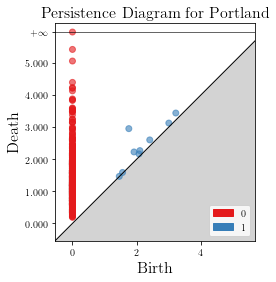

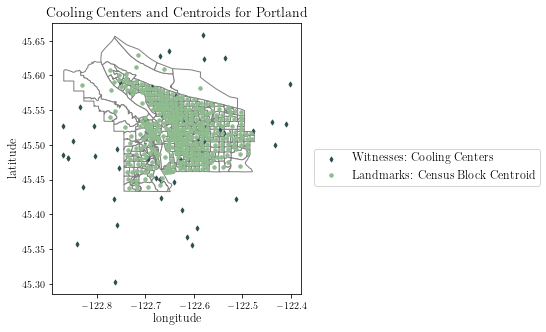

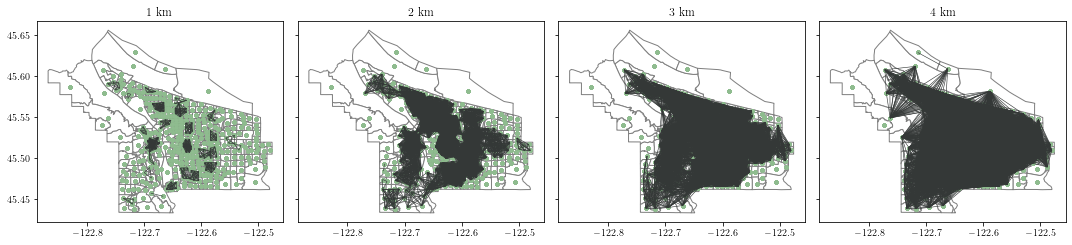

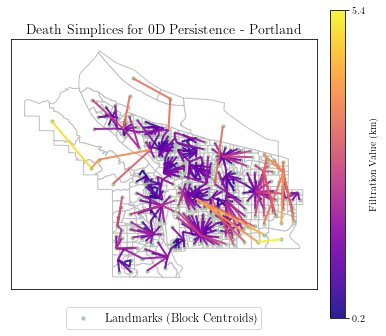

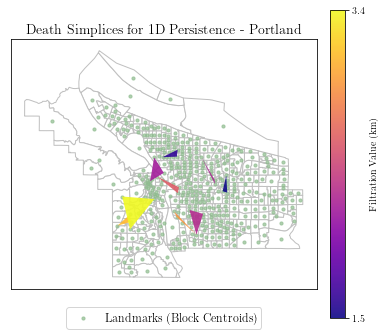

In [12]:
# load demographic data
df = pd.read_csv('Clean_U.S._Urban_Heat_Island_Mapping_Campaign.csv')
df.rename(columns={'geoid': 'GEOID'}, inplace=True)

# maps and cities to study
city_state_mapping = {
    'Portland': 'Oregon',
    'Austin': 'Texas',
    'Miami':'Florida',
    'Boston':'Massachusetts'
}



for city, state in city_state_mapping.items():
    L, W = load_and_preprocess_data(city)
    st, filt, birthdeath_pairs = plot_persistence_diagram(L, W, city)  
    shapefile_path = f"Shapefile_CB/{state}_CB.json"  
    L_plotting = np.copy(L)[:,::-1]
    W_plotting = np.copy(W)[:,::-1]
    
    gdf = plot_city_with_network(city, L_plotting, W_plotting, df, shapefile_path, st)

    #0D plot
    plot_death_simplices(city, gdf, L_plotting, st, filt, birthdeath_pairs)
    
    
    